In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import locale
from analyze_data import load_data, clean_data, analyze_data, format_currency, categorize_experience

# Set locale to Portuguese (Brazil) for currency formatting
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

/Users/lucasfaria/src/comp-scraping/comp_scraping/analyze_data.py:15: SyntaxWarning: invalid escape sequence '\d'
  df['Years of Experience'] = df['Years of Experience'].str.extract('(\d+)').astype(float)
/Users/lucasfaria/src/comp-scraping/comp_scraping/analyze_data.py:16: SyntaxWarning: invalid escape sequence '\d'
  df['Years at Company'] = df['Years at Company'].str.extract('(\d+)').astype(float)


'pt_BR.UTF-8'

# Software Engineer Salary Analysis in Brazil

This notebook analyzes software engineer salary data in Brazil based on information scraped from levels.fyi.

## Average Compensation by Experience Group

In [2]:
import os
import glob

def get_latest_csv(directory='data'):
    # Get a list of all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    
    # Sort the files by modification time, most recent first
    latest_csv = max(csv_files, key=os.path.getmtime)
    
    return latest_csv

# Load and clean the data
file_path = get_latest_csv()
print(f"Using data from: {file_path}")
df = load_data(file_path)
df = clean_data(df)

# Perform the analysis
results = analyze_data(df)

Using data from: data/brazil_software_engineer_salaries_2024-09-10-22-56-31.csv


/Users/lucasfaria/src/comp-scraping/comp_scraping/analyze_data.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.381,52 R$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_stats[stat] = format_currency(formatted_stats[stat])


## Compensation Statistics by Experience Group and Overall

In [3]:
def format_value(val, is_count):
    if isinstance(val, (int, float)):
        return '{:,.0f}'.format(val) if is_count else 'R${:,.2f}'.format(val)
    return val  # Return as is if it's already a string

def style_group_stats(df):
    formatted_df = df.copy()
    for col in df.columns:
        formatted_df[col] = df[col].apply(lambda x: format_value(x, col == 'count'))
    
    return (formatted_df.style
            .set_properties(**{'text-align': 'right', 'padding': '5px'})
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#f2f2f2'), 
                                             ('color', 'black'),
                                             ('font-weight', 'bold'),
                                             ('text-align', 'center'),
                                             ('border', '1px solid #ddd')]},
                {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
                {'selector': '', 'props': [('border-collapse', 'collapse'),
                                           ('font-family', 'Arial, sans-serif')]},
            ])
    )

def style_overall_stats(df):
    formatted_df = df.copy()
    formatted_df['Value'] = formatted_df.index.map(lambda x: format_value(df.loc[x, 'Value'], x == 'count'))
    
    return (formatted_df.style
            .set_properties(**{'text-align': 'right', 'padding': '5px'})
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#f2f2f2'), 
                                             ('color', 'black'),
                                             ('font-weight', 'bold'),
                                             ('text-align', 'center'),
                                             ('border', '1px solid #ddd')]},
                {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
                {'selector': '', 'props': [('border-collapse', 'collapse'),
                                           ('font-family', 'Arial, sans-serif')]},
            ])
    )

group_stats_df = pd.DataFrame(results['Compensation Stats by Experience Group'])
group_stats_df = group_stats_df[['count', 'mean', 'p50', 'p75', 'p90']]  # Reorder columns

overall_stats = pd.DataFrame(results['Overall Compensation Stats'], index=['Value']).T
overall_stats = overall_stats.reindex(['count', 'mean', 'p50', 'p75', 'p90'])  # Reorder rows

# Use the functions
print("Styled Compensation Statistics by Experience Group:")
display(style_group_stats(group_stats_df))

print("\nStyled Overall Compensation Statistics:")
display(style_overall_stats(overall_stats))

Styled Compensation Statistics by Experience Group:


,count,mean,p50,p75,p90
13+ years,88,"30.659,54 R$","26.773,38 R$","37.720,17 R$","56.927,64 R$"
8-12 years,183,"26.136,08 R$","22.833,33 R$","32.666,67 R$","44.882,58 R$"
4-7 years,436,"19.334,38 R$","15.518,83 R$","25.158,67 R$","36.344,71 R$"
0-3 years,227,"9.654,67 R$","8.333,33 R$","12.633,33 R$","19.119,65 R$"



Styled Overall Compensation Statistics:


,Value
count,934
mean,"19.381,52 R$"
p50,"15.078,04 R$"
p75,"25.175,17 R$"
p90,"37.500,00 R$"


## Overall Statistics

In [4]:
print(f"Correlation (Years of Experience vs Total Compensation): {results['Correlation (Years of Experience vs Total Compensation)']}")
print(f"Correlation (Years at Company vs Total Compensation): {results['Correlation (Years at Company vs Total Compensation)']}")

Correlation (Years of Experience vs Total Compensation): 0.43
Correlation (Years at Company vs Total Compensation): 0.08



Average Compensation by Company Tier:


,mean,median
Company Tier,,
Tier 3 (Global),"47.366,44 R$","45.149,50 R$"
Tier 2 (All Local),"29.013,33 R$","26.733,33 R$"
Tier 1 (Local),"12.457,44 R$","11.266,67 R$"


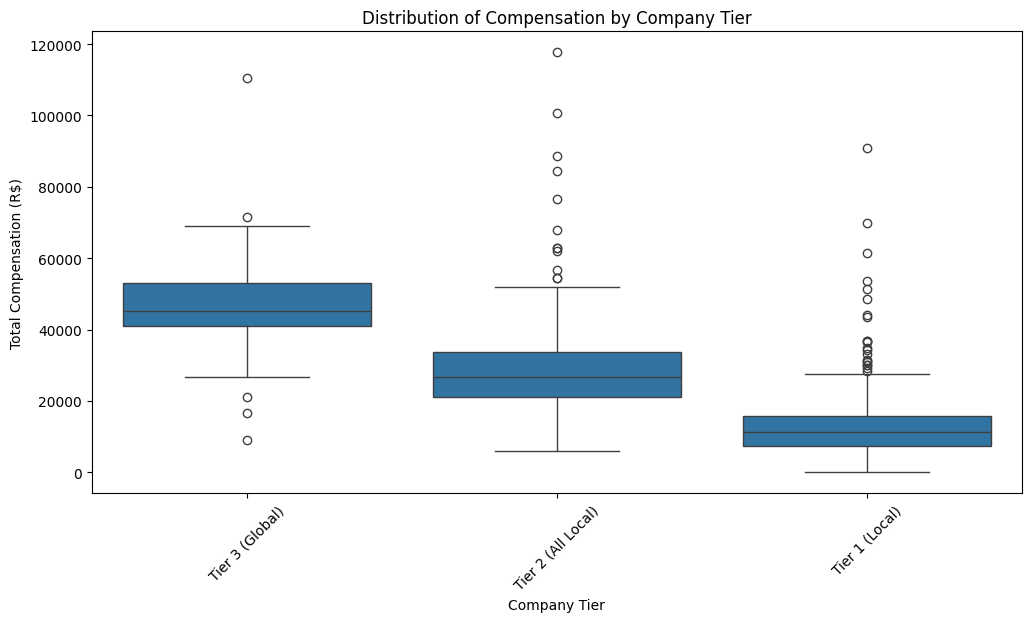

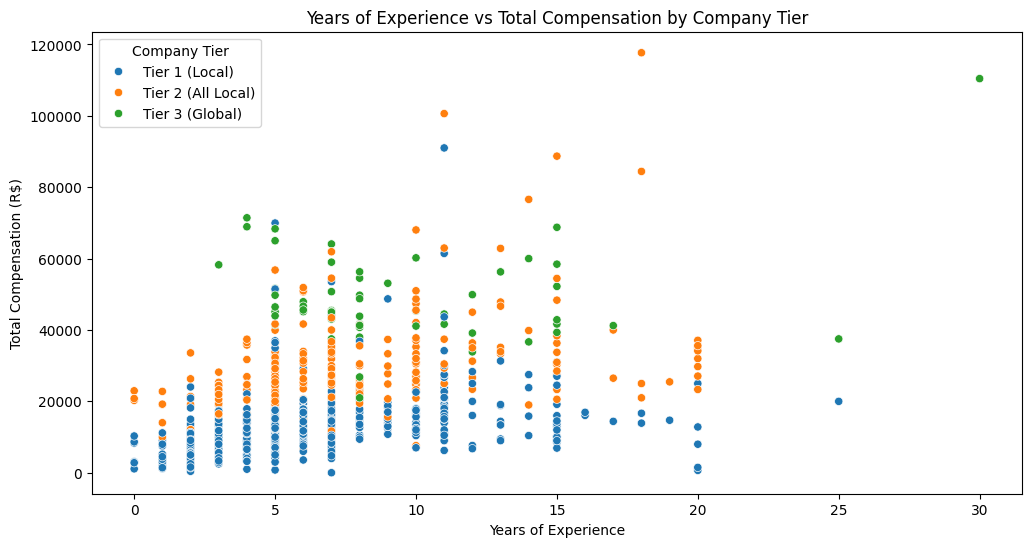

In [5]:
# Categorize companies into tiers
company_tiers = results['Company Tiers']

# Add tier information to the dataframe
df['Company Tier'] = df['Company'].map({company: tier 
                                        for tier, companies in company_tiers.items() 
                                        for company in companies})

# Calculate and display average compensation by tier
tier_stats = df.groupby('Company Tier')['Total Compensation'].agg(['mean', 'median'])
tier_stats = tier_stats.sort_values('mean', ascending=False)
tier_stats = tier_stats.map(lambda x: locale.currency(round(x, 2), grouping=True, symbol='R$'))

print("\nAverage Compensation by Company Tier:")
display(tier_stats)

# Visualize the distribution of compensation by tier
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company Tier', y='Total Compensation', data=df, order=['Tier 3 (Global)', 'Tier 2 (All Local)', 'Tier 1 (Local)'])
plt.title('Distribution of Compensation by Company Tier')
plt.ylabel('Total Compensation (R$)')
plt.xticks(rotation=45)
plt.show()

# Scatter plot of Years of Experience vs Total Compensation, colored by Company Tier
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Years of Experience', y='Total Compensation', hue='Company Tier', data=df)
plt.title('Years of Experience vs Total Compensation by Company Tier')
plt.xlabel('Years of Experience')
plt.ylabel('Total Compensation (R$)')
plt.legend(title='Company Tier')
plt.show()

## Top Paying Companies by Experience Group

In [6]:
for group, companies in results['Top Paying Companies by Experience Group'].items():
    print(f"\n{group}:")
    for company, data in companies['Total Compensation'].items():
        print(f"  {company}: {data}")


0-3 years:
  Google: 22.917,36 R$
  Uber: 20.322,39 R$
  Amazon: 17.413,35 R$
  Nubank: 14.907,24 R$
  iFood: 13.488,33 R$
  luizalabs: 12.922,22 R$
  Mercado Libre: 12.759,17 R$
  Quinto Andar: 12.100,00 R$
  Cadence Design Sy...: 11.737,08 R$
  NTT DATA: 10.755,56 R$

4-7 years:
  Brex: 57.341,65 R$
  Harness: 44.418,31 R$
  Uber: 37.873,24 R$
  Hinge Health: 36.725,40 R$
  Jungle Scout: 35.923,11 R$
  AgileEngine: 35.681,86 R$
  Turing: 33.860,25 R$
  Loadsmart: 33.438,68 R$
  Google: 31.357,40 R$
  Goldman Sachs: 30.000,00 R$

8-12 years:
  Google: 52.334,52 R$
  Loadsmart: 37.627,42 R$
  Amazon: 34.791,67 R$
  Hotel Engine: 30.512,33 R$
  Nubank: 29.708,76 R$
  C6 Bank: 25.312,50 R$
  BairesDev: 24.510,83 R$
  iFood: 21.723,99 R$
  Anonymous: 21.301,24 R$
  Mercado Libre: 20.742,42 R$

13+ years:
  Nubank: 53.486,00 R$
  Microsoft: 43.432,33 R$
  Amazon: 36.659,47 R$
  Mercado Libre: 17.940,42 R$


## Visualizations

### Distribution of Total Compensation

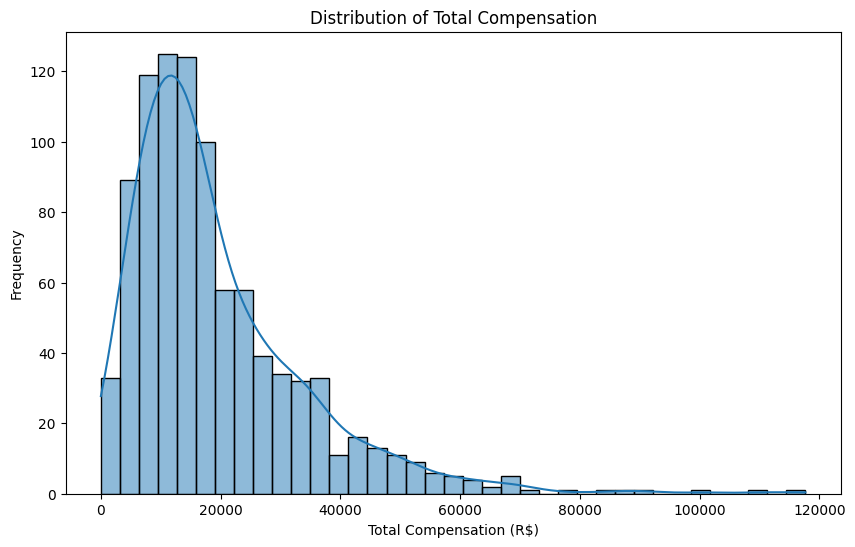

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Compensation'], kde=True)
plt.title('Distribution of Total Compensation')
plt.xlabel('Total Compensation (R$)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

### Total Compensation by Experience Group

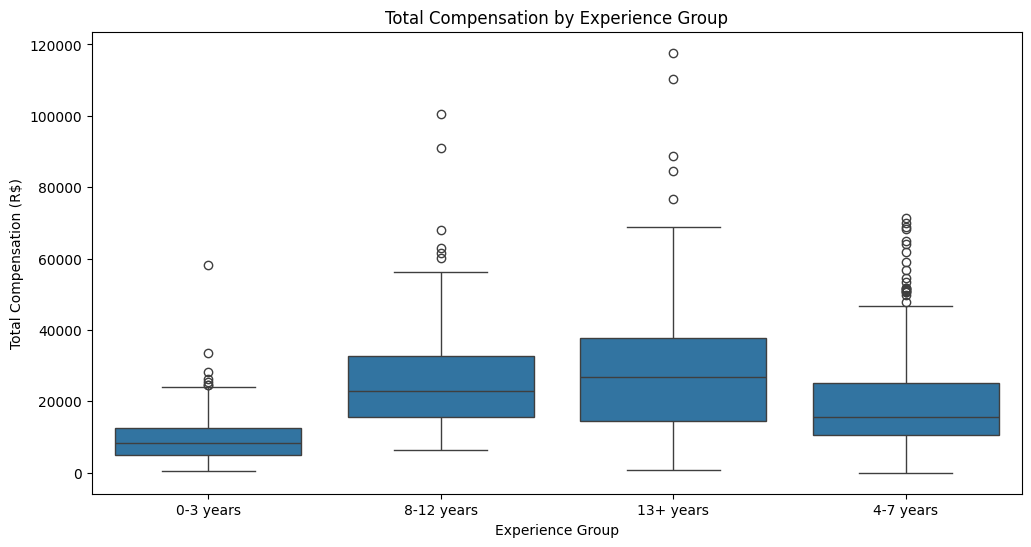

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Experience Group', y='Total Compensation', data=df)
plt.title('Total Compensation by Experience Group')
plt.ylabel('Total Compensation (R$)')
plt.show()

### Total Compensation vs Years of Experience

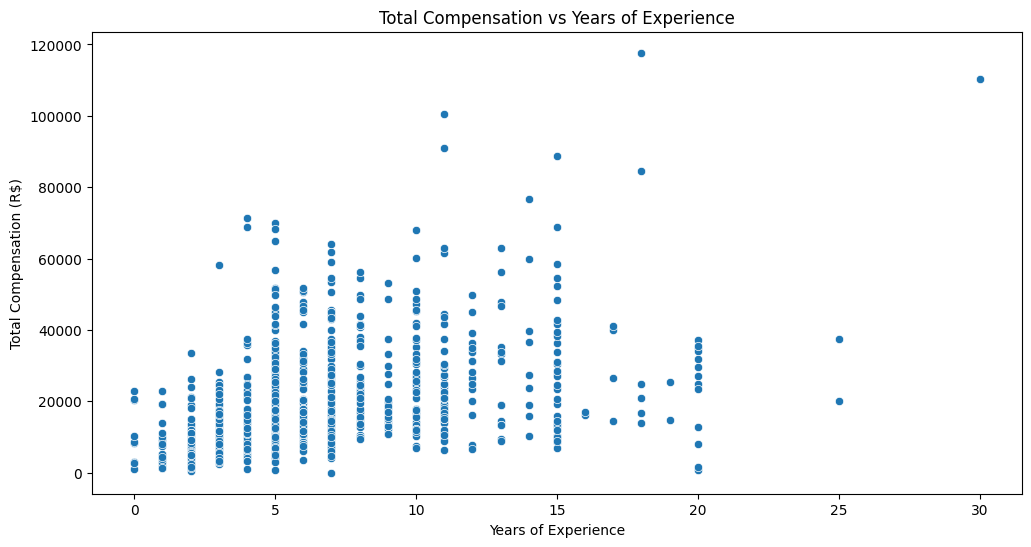

In [9]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Years of Experience', y='Total Compensation', data=df)
plt.title('Total Compensation vs Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Total Compensation (R$)')
plt.show()